In [1]:
from brian2 import *
prefs.codegen.target = 'cython' # for C compile

import matplotlib.pyplot as plt
import torch
import sbi.utils as utils

In [13]:
# differential equations are defined in the form of strings
tau = 10*ms

# multiline strings used to define equations
# one line per equation!
eqs = '''
dv/dt = (1-v)/tau : 1
'''
# : 1 defines the unit of v

In [14]:
G = NeuronGroup(1, eqs)

In [15]:
eqs = '''dv/dt = 1-v : 1''' # error is raised. tau missing -> dimensionally inconsistent
G = NeuronGroup(1, eqs)
run(100*ms)

BrianObjectException: Error encountered with object named "neurongroup_3".
Object was created here (most recent call only, full details in debug log):
  File "<ipython-input-15-2e16b98ab778>", line 2, in <module>
    G = NeuronGroup(1, eqs)

An error occurred when preparing an object. (See above for original error message and traceback.)

In [2]:
start_scope() # Ensures any Brian objects created before the func call aren’t included in the next simulator run

eqs = '''
dv/dt = (1-v)/tau : 1

tau : second
'''

G = NeuronGroup(2, eqs , method='exact')

G.tau = np.asarray([10,22])*ms

M = StateMonitor(G, 'v', record=True)

run(100*ms)

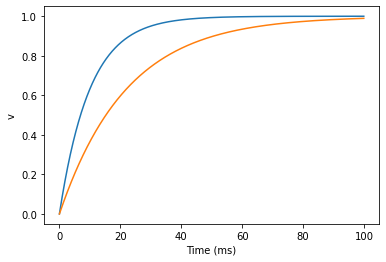

In [3]:
plot(M.t/ms, M.v.T)
xlabel('Time (ms)')
ylabel('v');

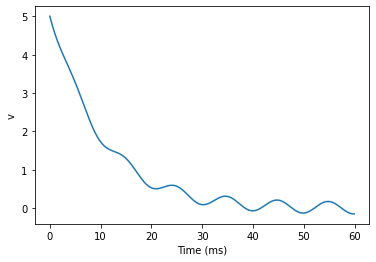

In [25]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (sin(2*pi*100*Hz*t)-v)/tau : 1
'''

G = NeuronGroup(1, eqs, method='euler') # exact doesnt work here
M = StateMonitor(G, 'v', record=0)

G.v = 5 # initial value

run(60*ms)

plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

Adding Spikes

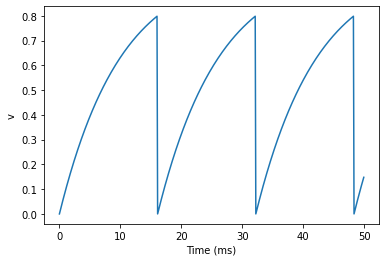

In [26]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')

M = StateMonitor(G, 'v', record=0)
run(50*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

Monitoring Spike times

In [27]:
start_scope()

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')

spikemon = SpikeMonitor(G)

run(50*ms)

print('Spike times: %s' % spikemon.t[:])

Spike times: [16.  32.1 48.2] ms


Using multiple neurons

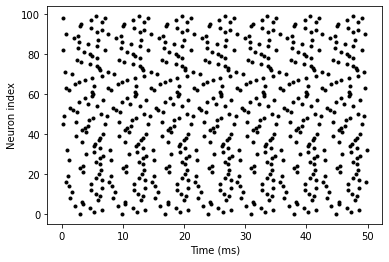

In [28]:
start_scope()

N = 100
tau = 10*ms
eqs = '''
dv/dt = (2-v)/tau : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='exact')
G.v = 'rand()'

spikemon = SpikeMonitor(G)

run(50*ms)

plot(spikemon.t/ms, spikemon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');


### Testing and modifying Yves' Implementation

#### To Do:
- understand initialize_parameter()
- ~~understand Br_sim()~~

- ~~parallel runs -> Neurongroup(N, ...)~~
- only recompile when network params change

- modify Br_sim() to be included in project


In [119]:
def Br_sim_simple(ps, current_val=300):
    """
    
    """
    
    ps = np.asarray(ps, float)
    N = ps.shape[0]
    
    ####################
    # Setting up the injection current, the model equations, further initialisations and run the model ;)
    
    I = TimedArray(np.vstack( [[0] + [current_val]*6 + [0]]*N ).T, dt = 100*ms)
    
    # The conductance-based model
    eqs = '''
         dVm/dt = -(gNa*m**3*h*(Vm - ENa) + gK*n**4*(Vm - EK) + gleak*(Vm - El) - I_inj + 
                   (gM*p*(Vm - EK))) / C : volt
                   
         I_inj = I(t, i)*pA : amp
         
         dm/dt = (alpham*(1-m) - betam*m) * t_adj_factor / rate_to_SS_factor : 1
         dn/dt = (alphan*(1-n) - betan*n) * t_adj_factor / rate_to_SS_factor : 1
         dh/dt = (alphah*(1-h) - betah*h) * t_adj_factor / rate_to_SS_factor : 1
         dp/dt = ((p_inf - p)/tau_p) * t_adj_factor : 1

         alpham = (-0.32/mV) * (Vm - VT - 13*mV) / (exp((-(Vm - VT - 13*mV))/(4*mV)) - 1)/ms : Hz
         betam = (0.28/mV) * (Vm - VT - 40*mV) / (exp((Vm - VT - 40*mV)/(5*mV)) - 1)/ms : Hz

         alphah = 0.128 * exp(-(Vm - VT - 17*mV) / (18*mV))/ms : Hz
         betah = 4/(1 + exp((-(Vm - VT - 40*mV)) / (5*mV)))/ms : Hz

         alphan = (-0.032/mV) * (Vm - VT - 15*mV) / (exp((-(Vm - VT - 15*mV)) / (5*mV)) - 1)/ms : Hz
         betan = 0.5*exp(-(Vm - VT - 10*mV) / (40*mV))/ms : Hz

         p_inf = 1/(1 + exp(-(Vm + 35*mV)/(10*mV))) : 1
         tau_p = (tau_max/1000)/(3.3 * exp((Vm + 35*mV)/(20*mV)) + exp(-(Vm + 35*mV)/(20*mV))) : second
         
         gNa : siemens
         gK : siemens
         gleak : siemens
         gM : siemens
         tau_max : second
         VT : volt
         El : volt
         rate_to_SS_factor : 1
         C : farad
         
         ENa : volt (shared)
         EK : volt (shared)
         
         t_adj_factor : 1 (shared)
         '''
    neurons = NeuronGroup(N, eqs, method='euler', name='neurons')
    
    ###################
    # Model parameter initialisations
    # Some are set, some are performed inference on
    # Inspired by Martin Pospischil et al. "Minimal Hodgkin-Huxley type models for
    # different classes of cortical and thalamaic neurons".
    area = ps[:,8]*umetre**2  # um2
    
    neurons.gNa = ps[:,0]*mS/cm**2*area
    neurons.gK = ps[:,1]*mS/cm**2*area
    neurons.gM = ps[:,2]*mS/cm**2*area
    neurons.gleak = ps[:,3]*mS/cm**2*area
    neurons.tau_max = ps[:,4]*second
    neurons.VT = ps[:,5]*mV
    neurons.El = ps[:,6]*mV
    neurons.C = 1*uF/cm**2*area
    neurons.Vm = ps[:,7]*mV
    neurons.rate_to_SS_factor = ps[:,9]
    neurons.ENa = 53*mV
    neurons.EK = -90*mV
    
    # It is important to adapt your kinetics to the temperature of your experiment
    # temperature coeff., https://en.wikipedia.org/wiki/Q10_(temperature_coefficient)
    T_1 = 36        # °C, from paper MartinPospischil et al.
    T_2 = 34        # °C, experiment was actually done at 25 °C
    Q10 = 3           # temperature coeff.
    
    neurons.t_adj_factor = Q10**((T_2 - T_1)/10)
    
    
    # set monitoring
    Vm_mon = StateMonitor(neurons, ['Vm', 'I_inj'], record = True, name = 'Vm_mon') # Specify what to record
    
    
    # init
    neurons.m = '1/(1 + betam/alpham)'         # Would be the solution when dm/dt = 0
    neurons.h = '1/(1 + betah/alphah)'         # Would be the solution when dh/dt = 0
    neurons.n = '1/(1 + betan/alphan)'         # Would be the solution when dn/dt = 0
    neurons.p = 'p_inf'                        # Would be the solution when dp/dt = 0
    
    # run simulation
    run(800*ms)
    
    return Vm_mon.t/ms, Vm_mon.Vm/mV, Vm_mon.I_inj/pA

In [120]:
prior_min = [.5, 1e-4, 1e-4, 1e-4, 50, -90, -110, -110, 5*1e2, 0.1]
prior_max = [80., 30, 0.6, 0.6, 3000, -40, -50, -50, 5*1e3, 3]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))
#test_params = prior.sample((3,))

In [121]:
#params = np.vstack([test_params[0]]*3)
#params[:,3] *= np.asarray([1.0,1.5,2])
#params = torch.tensor(params)

In [126]:
#set_device('cpp_standalone', build_on_run=False)
ts, v, I =  Br_sim_simple(params[None,0])
#device.build(directory='output', compile=True, run=True, debug=False)

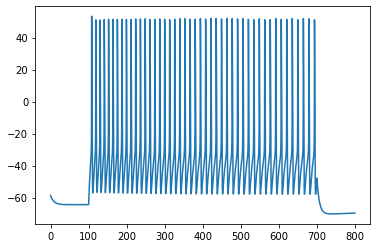

In [127]:
plt.plot(ts,v.T)
plt.show()